In [4]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import pickle

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import os
os.chdir('./drive/MyDrive/NLP')

In [18]:
xml_data = open('./dataset/articles-training-byarticle-20181122.xml', 'r').read()  # Read file
root = ET.XML(xml_data)

data = []

for i, child in enumerate(root):
    data.append([subchild.text for subchild in child])

df = pd.DataFrame(data).T  # Write in DF and transpose it

print(data[218])

['Hollywood will not easily recover from Harvey Weinstein -- not for a long time. The hypocrisy level has hit Defcon 1, 9.9 on the Richter scale.', "Hollywood’s politics have always been a self-serving charade, a liberal masquerade for a rapacious and lubricious lifestyle. But now, thanks to the Weinstein scandal, we see it more clearly than ever. And it couldn't be more repellent. (I had always thought Bill Clinton would have made the greatest studio executive of all time. Now I'm convinced of it.)", 'If conservative investors had any courage, this would be the time to make a hostile takeover of the movie business. Unfortunately, they don’t. I know this from bitter personal experience. Wealthy conservatives are delighted to support the Philharmonic, but when it comes to popular culture they turn away, as if afraid to get their hands dirty.', 'That this is a huge mistake should be obvious. They have abandoned the culture -- and our children -- to the creepiest people imaginable. What i

In [19]:
# loading labels
xml_data1 = open('./dataset/ground-truth-training-byarticle-20181122.xml', 'r').read()  # Read file
root1 = ET.XML(xml_data1)

labels = []

for i, child in enumerate(root1):
    if child.attrib['hyperpartisan']=='true':
        labels.append(1)
    else:
        labels.append(0)

print(len(labels))

645


In [20]:
# train test split
ratio = 0.1

perm = np.random.permutation(len(data))
idx_train = perm[:int(len(data)*(1-ratio))]
idx_test = perm[int(len(data)*(1-ratio)):]

data = np.array(data)
labels = np.array(labels)

X_train = data[idx_train]
y_train = labels[idx_train]

X_test = data[idx_test]
y_test = labels[idx_test]

print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

580 580
65 65


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [22]:
# tokenize data
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

sentences = []  # 2D list
for article in X_train:
  for paragraph in article:
    s = sent_tokenize(str(paragraph)) # sentence
    
    for single_sentence in s:
      sentences += [tokenizer.tokenize(single_sentence.lower())]
    
sentences[55]

['gop']

In [23]:
word_to_index = {}
index_to_word = {}
words_without_repitions = set()

for line in sentences:
  for j in line:
    words_without_repitions.add(j)

index = 0
for i in words_without_repitions:
  word_to_index[i]=index;
  index_to_word[index] = i;
  index+=1;

## CBOW

In [ ]:
def initialize_model(N,V):
    W1 = np.random.rand(N, V)
    W2 = np.random.rand(V, N)
    b1 = np.random.rand(N, 1)
    b2 = np.random.rand(V, 1)
    return W1, W2, b1, b2

def get_vectors(final_words, word_to_index, V , line ,j):
    x1 = np.zeros(V)
    x2 = np.zeros(V)
    x3 = np.zeros(V)
    x4 = np.zeros(V)
    sum = np.zeros(V)
    divisor = 0;
    if(j-2>=0):
      divisor+=1
      x1[word_to_index[line[j-2]]]=1;
    if(j-1>=0):
      divisor+=1
      x2[word_to_index[line[j-1]]]=1;
    if(j+1<len(line)):
      divisor+=1
      x3[word_to_index[line[j+1]]]=1;
    if(j+2<len(line)):
      divisor+=1
      x4[word_to_index[line[j+2]]]=1;

    if(j-2>=0):
      sum=sum+np.divide(x1,divisor)
    if(j-1>=0):
      sum=sum+np.divide(x2,divisor)
    if(j+1<len(line)):
      sum=sum+np.divide(x3,divisor)
    if(j+2<len(line)):
      sum=sum+np.divide(x4,divisor)

    out = np.zeros(V)
    out[word_to_index[line[j]]]=1;
    return sum,out

line = 0
j=0;
def get_batch(final_words, word_to_index, V, batch_size):
    global batches
    input = []
    output = []
    for line in final_words:
      for j in range(len(line)):
        x,y = get_vectors(final_words ,word_to_index , V, line,j)
        if len(input) < batch_size:
            input.append(x)
            output.append(y)
        else:
            copy1 = np.empty_like(input)
            copy1[:] = input

            copy2 = np.empty_like(output)
            copy2[:] = output

            input = []
            output = []
            # print(copy1)
            # print(copy2)
            yield np.array(copy1).T, np.array(copy2).T

    # return np.array(input).T, np.array(output).T

def softmax(z):
    e_z = np.exp(z)
    yhat = e_z/np.sum(e_z, axis=0)
    return yhat

def forward_prop(x, W1, W2, b1, b2):
    h = np.dot(W1, x)
    z = np.dot(W2, h)
    return z, h

def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    l1 = np.dot(W2.T, yhat - y)
    # l1 = np.maximum(l1, 0)
    grad_W1 = np.dot(l1, x.T) / batch_size
    grad_W2 = np.dot(yhat - y, h.T) / batch_size
    grad_b1 = np.sum(l1, axis = 1, keepdims = True) / batch_size
    grad_b2 = np.sum(yhat - y, axis = 1, keepdims = True) / batch_size
    
    return grad_W1, grad_W2, grad_b1, grad_b2

In [ ]:
V = len(words_without_repitions)
num_iters = 50000
N = 100
alpha = 0.03

def gradient_descent():
    global costs
    W1, W2, b1, b2 = initialize_model(N, V)
    batch_size = 10
    iters = 0
    while True:
        # [v for v in get_batch(final_words, word_to_index, V, batch_size)]
        # x = v[0]
        # y = v[1]

        for x,y in get_batch(sentences, word_to_index, V, batch_size):
          z, h = forward_prop(x, W1, W2, b1, b2)
          yhat = softmax(z)
          
          grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)

          W1 -= alpha * grad_W1 
          W2 -= alpha * grad_W2
          b1 -= alpha * grad_b1
          b2 -= alpha * grad_b2

          iters += 1
          if iters == num_iters: 
              break

        if iters == num_iters: 
              break    
    return W2

w = gradient_descent()
  
print(w)

[[0.07531571 0.34446108 0.39229854 ... 0.07314928 1.00974848 0.9056541 ]
 [0.32503526 0.03193449 0.45110166 ... 0.83899605 0.03489792 0.28134073]
 [0.4266793  0.88102249 0.97944737 ... 0.91044364 0.2615907  0.52856089]
 ...
 [0.72776307 0.28644043 0.40280095 ... 0.01107635 0.97562479 0.81080025]
 [0.39712116 0.90699151 0.10138985 ... 0.50880765 0.21259988 0.57561217]
 [0.76874967 0.93171665 0.33796807 ... 0.36539586 0.18993712 0.61253675]]


In [ ]:
# store embeddings
ans = []
for i in range(0,len(w)):
  ans.append(w[i])

file_name = "embedding.pkl"

open_file = open(file_name, "wb")
pickle.dump(ans, open_file)
open_file.close()

file_name = "word_to_index.pkl"

open_file = open(file_name, "wb")
pickle.dump(word_to_index, open_file)
open_file.close()

In [29]:
# loading embeddings
w = pickle.load(open('embedding.pkl', 'rb'))
word_to_index = pickle.load(open('word_to_index.pkl', 'rb'))

In [30]:
word_to_index['c']

10178

In [31]:
np.array(X_train).shape

(580,)

In [32]:
# preparing data for the classifier

article_feature_vec = []
for article in X_train:

  sentence_embedding = []
  for paragraph in article:
    s = sent_tokenize(str(paragraph))
    for sentence in s:
      val = []
      for word in sentence:
        if word in word_to_index: # check if word is present
          val.append(np.mean(w[word_to_index[word]]))
      if len(val):
        sentence_embedding.append(np.mean(val))
      
  article_feature_vec += [sentence_embedding]

In [33]:
article_embedding = pd.DataFrame(article_feature_vec)
article_embedding

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155
0,0.572775,0.571560,0.564736,0.577231,0.564554,0.572686,0.582387,0.568886,0.561590,0.572899,0.578270,0.575884,0.570324,0.565057,0.531325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.531325,0.565731,0.581676,0.556979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.577120,0.576445,0.575460,0.571758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.531325,0.570516,0.565557,0.574467,0.570219,0.571594,0.572267,0.568794,0.577528,0.565341,0.571973,0.569791,0.569627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.574396,0.576557,0.576057,0.576367,0.576006,0.572814,0.571083,0.574107,0.579404,0.564947,0.577099,0.587182,0.579030,0.575869,0.568521,0.585412,0.581157,0.575059,0.572619,0.568951,0.573539,0.569337,0.573644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,0.566507,0.560991,0.570621,0.574943,0.575574,0.582014,0.544238,0.568745,0.573172,0.574327,0.582501,0.576362,0.570759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
576,0.563341,0.568854,0.571712,0.577151,0.579402,0.585123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577,0.608212,0.571513,0.531325,0.575726,0.570671,0.557407,0.567391,0.583405,0.568151,0.574809,0.564097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
578,0.570336,0.563572,0.570564,0.565048,0.563291,0.565579,0.565387,0.555277,0.584334,0.568798,0.558080,0.568935,0.568264,0.574086,0.570953,0.570259,0.560731,0.562987,0.566424,0.569347,0.572218,0.574559,0.574716,0.569811,0.572482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [34]:
# Keep only the columns with at least 1/4 non-NA values.
article_embedding.dropna(thresh=article_embedding.shape[0]/4, axis=1, inplace=True)
article_embedding

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0.572775,0.571560,0.564736,0.577231,0.564554,0.572686,0.582387,0.568886,0.561590,0.572899,0.578270,0.575884,0.570324,0.565057,0.531325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.531325,0.565731,0.581676,0.556979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.577120,0.576445,0.575460,0.571758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.531325,0.570516,0.565557,0.574467,0.570219,0.571594,0.572267,0.568794,0.577528,0.565341,0.571973,0.569791,0.569627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.574396,0.576557,0.576057,0.576367,0.576006,0.572814,0.571083,0.574107,0.579404,0.564947,0.577099,0.587182,0.579030,0.575869,0.568521,0.585412,0.581157,0.575059,0.572619,0.568951,0.573539,0.569337,0.573644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,0.566507,0.560991,0.570621,0.574943,0.575574,0.582014,0.544238,0.568745,0.573172,0.574327,0.582501,0.576362,0.570759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
576,0.563341,0.568854,0.571712,0.577151,0.579402,0.585123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577,0.608212,0.571513,0.531325,0.575726,0.570671,0.557407,0.567391,0.583405,0.568151,0.574809,0.564097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
578,0.570336,0.563572,0.570564,0.565048,0.563291,0.565579,0.565387,0.555277,0.584334,0.568798,0.558080,0.568935,0.568264,0.574086,0.570953,0.570259,0.560731,0.562987,0.566424,0.569347,0.572218,0.574559,0.574716,0.569811,0.572482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
article_embedding.fillna(method='ffill',axis=1,inplace=True)
article_embedding[-5:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
575,0.566507,0.560991,0.570621,0.574943,0.575574,0.582014,0.544238,0.568745,0.573172,0.574327,0.582501,0.576362,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759,0.570759
576,0.563341,0.568854,0.571712,0.577151,0.579402,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123,0.585123
577,0.608212,0.571513,0.531325,0.575726,0.570671,0.557407,0.567391,0.583405,0.568151,0.574809,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097,0.564097
578,0.570336,0.563572,0.570564,0.565048,0.563291,0.565579,0.565387,0.555277,0.584334,0.568798,0.558080,0.568935,0.568264,0.574086,0.570953,0.570259,0.560731,0.562987,0.566424,0.569347,0.572218,0.574559,0.574716,0.569811,0.572482,0.572482,0.572482,0.572482,0.572482,0.572482,0.572482,0.572482,0.572482,0.572482
579,0.575929,0.575404,0.570598,0.572331,0.566275,0.586355,0.569603,0.587422,0.580944,0.570670,0.572362,0.585161,0.572933,0.581696,0.575355,0.567518,0.581270,0.554749,0.597801,0.552859,0.552859,0.552859,0.552859,0.552859,0.552859,0.552859,0.552859,0.552859,0.552859,0.552859,0.552859,0.552859,0.552859,0.552859


In [36]:
print(article_embedding.isnull().sum().sum())

34


In [40]:
article_embedding.fillna(method='bfill',axis=1,inplace=True)
article_embedding.fillna(0,inplace=True)
print(article_embedding.isnull().sum().sum())

0


In [38]:
# hyper-parameter tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

hyper_params = {
    'n_estimators': range(100,1000,100),
    'criterion': ['gini','entropy'],
    'max_depth': range(3,20),
    # 'min_samples_leaf': range(5,100),
    'random_state': range(0,100),
    'max_features': ['auto', 'sqrt', 'log2']
}

In [41]:
clf = RandomizedSearchCV(RandomForestClassifier(), hyper_params)

# Training
clf.fit(article_embedding, y_train)

model = clf.best_estimator_
print(model)

RandomForestClassifier(max_depth=12, max_features='sqrt', n_estimators=900,
                       random_state=48)


In [42]:
# preparing test data
article_feature_vec = []
for article in X_test:

  sentence_embedding = []
  for paragraph in article:
    s = sent_tokenize(str(paragraph))
    for sentence in s:
      val = []
      for word in sentence:
        if word in word_to_index: # check if word is present
          val.append(np.mean(w[word_to_index[word]]))
      if len(val):
        sentence_embedding.append(np.mean(val))
      
  article_feature_vec += [sentence_embedding]

In [43]:
test_data = pd.DataFrame(article_feature_vec)

# change dimension according to train data
del_cols = test_data.shape[1]-article_embedding.shape[1]
test_data = test_data.iloc[:,:-del_cols]

test_data.fillna(method='ffill',axis=1,inplace=True)
test_data.fillna(method='bfill',axis=1,inplace=True)

In [44]:
y_pred = model.predict(test_data)
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1])

In [45]:
from sklearn import metrics 
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred)*100,'%')
print("F1 Score: ", metrics.f1_score(y_test, y_pred)*100,'%')

Accuracy:  64.61538461538461 %
F1 Score:  46.51162790697674 %


In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.82      0.74        39
           1       0.59      0.38      0.47        26

    accuracy                           0.65        65
   macro avg       0.63      0.60      0.60        65
weighted avg       0.64      0.65      0.63        65



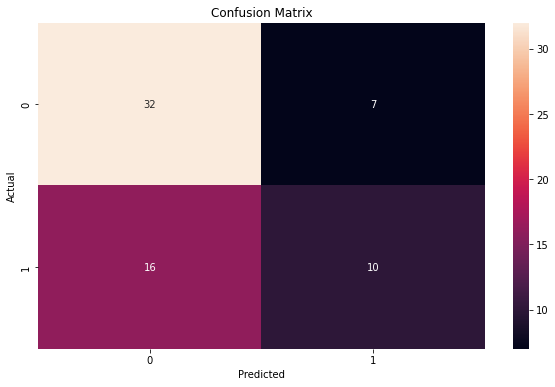

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Gensim model
Testing the same concept using gensim embeddings for bias detection

In [ ]:
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# !gzip -d GoogleNews-vectors-negative300.bin.gz

--2021-12-10 18:37:12--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.64.251
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.64.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  47.8MB/s    in 34s     

2021-12-10 18:37:46 (46.6 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [48]:
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

Found 3000000 word vectors of word2vec


In [100]:
word2vec['camera'].shape

(300,)

In [53]:
# preparing data for the classifier

# X_train,X_train = 2D list
# returns dataframe
def prepare_data(X_train,X_test,thresh=None):
  # train data
  article_feature_vec = []
  for article in X_train:

    sentence_embedding = []
    for paragraph in article:
      s = sent_tokenize(str(paragraph))
      for sentence in s:
        val = []
        for word in sentence:
          if word in word2vec: # check if word is present
            val.append(np.mean(word2vec[word]))
        if len(val):
          sentence_embedding.append(np.mean(val))
        
    article_feature_vec += [sentence_embedding]
  
  ret = pd.DataFrame(article_feature_vec)
  ret.dropna(thresh=ret.shape[0]*thresh, axis=1, inplace=True)

  ret.fillna(method='ffill',axis=1,inplace=True)
  ret.fillna(method='bfill',axis=1,inplace=True)
  ret.fillna(0,inplace=True)

  # test data
  article_feature_vec = []
  for article in X_test:

    sentence_embedding = []
    for paragraph in article:
      s = sent_tokenize(str(paragraph))
      for sentence in s:
        val = []
        for word in sentence:
          if word in word2vec: # check if word is present
            val.append(np.mean(word2vec[word]))
        if len(val):
          sentence_embedding.append(np.mean(val))
        
    article_feature_vec += [sentence_embedding]
  
  ret2 = pd.DataFrame(article_feature_vec)
  del_cols = ret2.shape[1]-ret.shape[1]
  ret2 = ret2.iloc[:,:-del_cols]

  ret2.fillna(method='ffill',axis=1,inplace=True)
  ret2.fillna(method='bfill',axis=1,inplace=True)
  ret2.fillna(0,inplace=True)
  
  return ret,ret2

gensim_train_data, gensim_test_data = prepare_data(X_train, X_test, thresh=0.25)

In [51]:
print(gensim_train_data)
print(gensim_test_data)

           0         1         2   ...        31        32        33
0   -0.005024 -0.006143 -0.006147  ... -0.009518 -0.009518 -0.009518
1   -0.009518 -0.004481 -0.005257  ... -0.001960 -0.001960 -0.001960
2   -0.005521 -0.005013 -0.004803  ... -0.005131 -0.005131 -0.005131
3   -0.009518 -0.005140 -0.005861  ... -0.005692 -0.005692 -0.005692
4   -0.004588 -0.005273 -0.005203  ... -0.004750 -0.004750 -0.004750
..        ...       ...       ...  ...       ...       ...       ...
575 -0.005570 -0.005961 -0.004564  ... -0.008992 -0.008992 -0.008992
576 -0.005472 -0.007113 -0.005386  ... -0.004402 -0.004402 -0.004402
577 -0.002103 -0.005642 -0.009518  ... -0.007630 -0.007630 -0.007630
578 -0.003384 -0.002067 -0.005902  ... -0.003446 -0.003446 -0.003446
579 -0.006173 -0.005809 -0.004975  ... -0.008142 -0.008142 -0.008142

[580 rows x 34 columns]
          0         1         2   ...        31        32        33
0  -0.006087 -0.006087 -0.006087  ... -0.006087 -0.006087 -0.006087
1  -0.00465

In [54]:
clf = RandomForestClassifier(n_estimators = 400)
clf.fit(gensim_train_data, y_train)
y_pred = clf.predict(gensim_test_data)

In [55]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred)*100,'%')
print("F1 Score: ", metrics.f1_score(y_test, y_pred)*100,'%')
print(classification_report(y_test, y_pred))

Accuracy:  55.38461538461539 %
F1 Score:  29.268292682926834 %
              precision    recall  f1-score   support

           0       0.60      0.77      0.67        39
           1       0.40      0.23      0.29        26

    accuracy                           0.55        65
   macro avg       0.50      0.50      0.48        65
weighted avg       0.52      0.55      0.52        65



## GloVe model

In [1]:
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip -O /tmp/glove.6B.zip

--2021-12-11 15:43:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-11 15:43:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-11 15:43:52--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’

/t

In [2]:
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [5]:
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [31]:
print(embeddings_index["camera"])

[-0.15433   -0.64416    0.10601    0.29336    0.15603    0.26157
 -0.062361   0.39104    0.27071   -0.1475     0.68665   -0.35519
 -0.059875  -0.25777    0.65901    0.53279   -0.31004    0.3868
  0.79289   -0.30342   -0.21298   -0.079137  -0.13125   -0.30356
  1.0597    -0.10637    0.11868    0.30544    0.054878  -0.10311
  0.2921     0.59605   -0.91195    1.132      1.0783    -0.33453
 -0.23376   -0.26142    1.3293    -0.76971    0.12998   -0.40786
 -0.32376    0.43906   -1.0648    -0.31423   -0.077851  -0.06993
  0.18887   -0.019047  -0.1836     0.17368   -0.066262   1.6467
  0.55081   -1.8841    -0.41274    0.35008    1.1006    -0.49432
  0.46349    1.499      0.0046456  0.73574    0.052391   0.31359
  0.53659   -0.061741  -0.32042    1.1158     0.20671    0.065164
  1.0298     0.14286    0.095693   0.12563    0.24062    0.064921
  0.26017   -0.063592   0.41458   -0.047662   0.22585   -0.18949
 -1.715     -0.23938    0.54405    0.12833    0.51828   -0.6509
  0.29557    0.37531    0.

In [35]:
# preparing data for the classifier

# X_train,X_train = 2D list
# returns dataframe
def prepare_data(X_train,X_test,thresh=None):
  # train data
  article_feature_vec = []
  for article in X_train:

    sentence_embedding = []
    for paragraph in article:
      s = sent_tokenize(str(paragraph))
      for sentence in s:
        val = []
        for word in sentence:
          if word in embeddings_index:
            val.append(np.mean(embeddings_index[word]))
        if len(val):
          sentence_embedding.append(np.mean(val))
        
    article_feature_vec += [sentence_embedding]
  
  ret = pd.DataFrame(article_feature_vec)
  ret.dropna(thresh=ret.shape[0]*thresh, axis=1, inplace=True)

  ret.fillna(method='ffill',axis=1,inplace=True)
  ret.fillna(method='bfill',axis=1,inplace=True)
  ret.fillna(0,inplace=True)

  # test data
  article_feature_vec = []
  for article in X_test:

    sentence_embedding = []
    for paragraph in article:
      s = sent_tokenize(str(paragraph))
      for sentence in s:
        val = []
        for word in sentence:
          if word in embeddings_index:
            val.append(np.mean(embeddings_index[word]))
        if len(val):
          sentence_embedding.append(np.mean(val))
        
    article_feature_vec += [sentence_embedding]
  
  ret2 = pd.DataFrame(article_feature_vec)
  del_cols = ret2.shape[1]-ret.shape[1]
  ret2 = ret2.iloc[:,:-del_cols]

  ret2.fillna(method='ffill',axis=1,inplace=True)
  ret2.fillna(method='bfill',axis=1,inplace=True)
  ret2.fillna(0,inplace=True)
  
  return ret,ret2

glove_train_data, glove_test_data = prepare_data(X_train, X_test, thresh=0.25)

In [36]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 900)
clf.fit(glove_train_data, y_train)
y_pred = clf.predict(glove_test_data)

In [37]:
from sklearn import metrics 
from sklearn.metrics import classification_report

print("Accuracy: ", metrics.accuracy_score(y_test, y_pred)*100,'%')
print("F1 Score: ", metrics.f1_score(y_test, y_pred)*100,'%')
print(classification_report(y_test, y_pred))

Accuracy:  63.07692307692307 %
F1 Score:  36.84210526315789 %
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        47
           1       0.35      0.39      0.37        18

    accuracy                           0.63        65
   macro avg       0.55      0.56      0.55        65
weighted avg       0.64      0.63      0.64        65



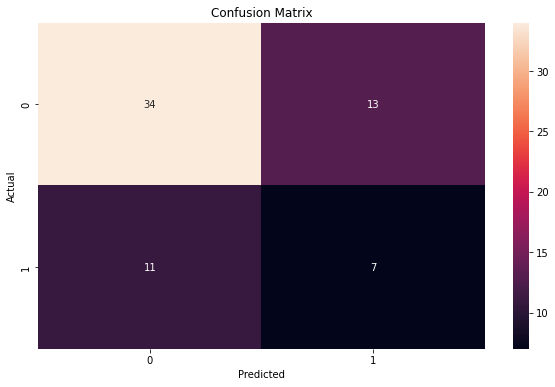

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()